In [1]:
import numpy as np
import tensorflow as tf
import sklearn as sk
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.layers import  Lambda, Dense, Dropout, BatchNormalization, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.losses import mse, binary_crossentropy
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

In [2]:

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")


In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
y_train_valid -= 769
y_test -= 769
# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 500, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train_np, x_valid_np) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train_np, y_valid_np) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train_np.shape)
print('Shape of validation set:',x_valid_np.shape)
print('Shape of training labels:',y_train_np.shape)
print('Shape of validation labels:',y_valid_np.shape)


# Converting the labels to categorical variables for multiclass classification
y_train_np = to_categorical(y_train_np, 4)
y_valid_np = to_categorical(y_valid_np, 4)
y_test_np = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train_np.shape)
print('Shape of validation labels after categorical conversion:',y_valid_np.shape)
print('Shape of test labels after categorical conversion:',y_test_np.shape)

# Adding width of the segment to be 1
x_train_np = x_train_np.reshape(x_train_np.shape[0], x_train_np.shape[1], x_train_np.shape[2], 1)
x_valid_np = x_valid_np.reshape(x_valid_np.shape[0], x_valid_np.shape[1], x_train_np.shape[2], 1)
x_test_np = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train_np.shape)
print('Shape of validation set after adding width info:',x_valid_np.shape)
print('Shape of test set after adding width info:',x_test_np.shape)


# Reshaping the training and validation dataset
x_train_np = np.swapaxes(x_train_np, 1,3)
x_train_np = np.swapaxes(x_train_np, 1,2)
x_valid_np = np.swapaxes(x_valid_np, 1,3)
x_valid_np = np.swapaxes(x_valid_np, 1,2)
x_test_np = np.swapaxes(x_test_np, 1,3)
x_test_np = np.swapaxes(x_test_np, 1,2)
print('Shape of training set after dimension reshaping:',x_train_np.shape)
print('Shape of validation set after dimension reshaping:',x_valid_np.shape)
print('Shape of test set after dimension reshaping:',x_test_np.shape)


Shape of training set: (1615, 22, 1000)
Shape of validation set: (500, 22, 1000)
Shape of training labels: (1615,)
Shape of validation labels: (500,)
Shape of training labels after categorical conversion: (1615, 4)
Shape of validation labels after categorical conversion: (500, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (1615, 22, 1000, 1)
Shape of validation set after adding width info: (500, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: (1615, 1000, 1, 22)
Shape of validation set after dimension reshaping: (500, 1000, 1, 22)
Shape of test set after dimension reshaping: (443, 1000, 1, 22)


In [7]:
class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        #self.accuracy_tracker = keras.metrics.Accuracy(name = 'accuracy')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            #self.accuracy_tracker        
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            #accuracy = self.accuracy_tracker.result()
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        #self.accuracy_tracker().update_state(accuracy)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            #"accuracy":self.accuracy_tracker.result()
        }
    

In [45]:
latent_dim = 2
vae_filts1 = 100

## Build Encoder
encoder_inputs = keras.Input(shape=(1000,1,22))
x = layers.Conv2D(vae_filts1,(10,1),strides = (2,1), activation="relu",padding = 'same')(encoder_inputs)
conv_shape = K.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(200,activation = 'relu')(x)


#x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z_log_var += 1e-8
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()


## Build the decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(200,activation = 'relu')(latent_inputs)
x = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation="relu")(x)
x = layers.Reshape((conv_shape[1],conv_shape[2],conv_shape[3]))(x)
decoder_outputs = layers.Conv2DTranspose(22,(10,1),strides=(2,1),activation = 'elu',padding='same')(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


vae = VAE(encoder, decoder)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1000, 1, 22  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_11 (Conv2D)             (None, 500, 1, 100)  22100       ['input_5[0][0]']                
                                                                                                  
 flatten_4 (Flatten)            (None, 50000)        0           ['conv2d_11[0][0]']              
                                                                                                  
 dense_7 (Dense)                (None, 200)          10000200    ['flatten_4[0][0]']        

In [46]:
learning_rate = 1e-3
decay = 1e-6
vae_optimizer = keras.optimizers.Adam(lr=learning_rate, decay = decay)

vae.compile(optimizer=vae_optimizer)
vae.fit(x_train_np, epochs = 30, batch_size=128, verbose = True)

Epoch 1/30


/usr/local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


13/13 [==============================] - 5s 286ms/step - loss: 2508844.9875 - reconstruction_loss: 3868.7878 - kl_loss: 2416278.2500
Epoch 2/30
13/13 [==============================] - 4s 285ms/step - loss: 610709.7500 - reconstruction_loss: 3710.4011 - kl_loss: 620236.6875
Epoch 3/30
13/13 [==============================] - 4s 303ms/step - loss: 388733.7902 - reconstruction_loss: 2980.9048 - kl_loss: 287962.1250
Epoch 4/30
13/13 [==============================] - 4s 318ms/step - loss: 29336.0904 - reconstruction_loss: 2816.2046 - kl_loss: 24665.5195
Epoch 5/30
13/13 [==============================] - 4s 348ms/step - loss: 6772.1153 - reconstruction_loss: 1239.7150 - kl_loss: 5210.6094
Epoch 6/30
13/13 [==============================] - 5s 357ms/step - loss: 7082.3068 - reconstruction_loss: 179.9312 - kl_loss: 10167.0684
Epoch 7/30
13/13 [==============================] - 5s 381ms/step - loss: 37084.4375 - reconstruction_loss: -806.3766 - kl_loss: 40316.1328
Epoch 8/30
13/13 [=========

In [49]:
#Passing real data through VAE to generate "fake" data
z_sample = vae.encoder([x_train_np])[2]
x_decoded = vae.decoder([z_sample])

Before VAE


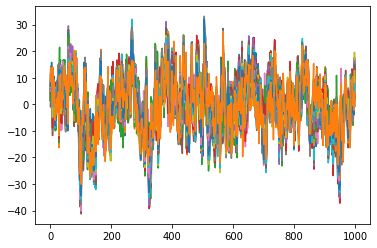

After VAE:


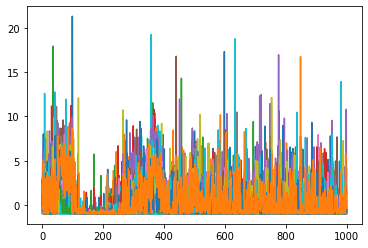

In [57]:
x_tane = x_train_np.reshape(1615,1000,22)
print('Before VAE')
plt.plot(x_tane[5])
plt.show()

print('After VAE:')
x_vae = np.array(x_decoded).reshape(1615,1000,22)
plt.plot(x_vae[1])
plt.show()

#Adding fake image data to existing real data
x_train3 = np.concatenate((x_train_np,x_decoded), axis = 0)
y_train3 = np.concatenate((y_train_np,y_train_np), axis = 0)

In [61]:
inputs = keras.Input(shape=(1000, 1, 22))
x = Conv2D(50,(10,1),padding = 'same',activation = 'relu')(inputs)
x = MaxPooling2D(pool_size = (3,1), padding = 'same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Conv2D(100,(10,1),padding = 'same',activation = 'relu')(x)
x = MaxPooling2D(pool_size = (3,1), padding = 'same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Conv2D(200,(10,1),padding = 'same',activation = 'relu')(x)
x = MaxPooling2D(pool_size = (3,1), padding = 'same')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)


x = Flatten()(x)
x = Dense(4)(x)
x = Activation('softmax')(x)
vae_cnn = Model(inputs,x, name = 'CNN')
vae_cnn_sub1 = Model(inputs,x, name = 'Subject1')
vae_cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1000, 1, 22)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 1000, 1, 50)       11050     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 334, 1, 50)       0         
 g2D)                                                            
                                                                 
 batch_normalization_19 (Bat  (None, 334, 1, 50)       200       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 334, 1, 50)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 334, 1, 100)       50100   

In [62]:
epochs = 50
optimizer = keras.optimizers.Adam(lr=learning_rate, decay = 1e-6)


# Compiling the model
vae_cnn.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

# Training and validating the model
vae_cnn_results = vae_cnn.fit(x_train3,
             y_train3,
             batch_size=64,
             epochs=epochs,
             validation_data = (x_valid_np,y_valid_np),
             verbose=True)

Epoch 1/50
51/51 [==============================] - 10s 192ms/step - loss: 2.3354 - accuracy: 0.2632 - val_loss: 2.4219 - val_accuracy: 0.3440
Epoch 2/50
51/51 [==============================] - 11s 207ms/step - loss: 2.0025 - accuracy: 0.3025 - val_loss: 2.2623 - val_accuracy: 0.3600
Epoch 3/50
51/51 [==============================] - 11s 211ms/step - loss: 2.1573 - accuracy: 0.3096 - val_loss: 2.0585 - val_accuracy: 0.3180
Epoch 4/50
51/51 [==============================] - 10s 204ms/step - loss: 1.8878 - accuracy: 0.3313 - val_loss: 1.5782 - val_accuracy: 0.3800
Epoch 5/50
51/51 [==============================] - 11s 211ms/step - loss: 1.7570 - accuracy: 0.3498 - val_loss: 1.5286 - val_accuracy: 0.4280
Epoch 6/50
51/51 [==============================] - 11s 208ms/step - loss: 1.6794 - accuracy: 0.3635 - val_loss: 1.5575 - val_accuracy: 0.4040
Epoch 7/50
51/51 [==============================] - 11s 210ms/step - loss: 1.6965 - accuracy: 0.3666 - val_loss: 1.4173 - val_accuracy: 0.4220

In [64]:
val_loss, val_acc = vae_cnn.evaluate(x_test_np,y_test_np)
print('VAE+CNN: ', val_loss,val_acc)

14/14 [==============================] - 0s 27ms/step - loss: 1.3506 - accuracy: 0.5260
VAE+CNN:  1.3505576848983765 0.5259593725204468


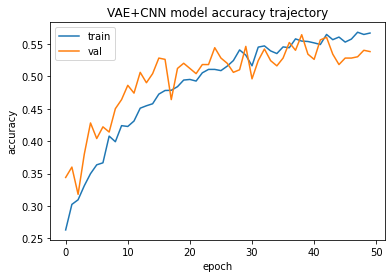

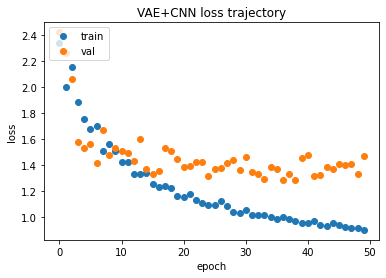

In [65]:
# Plotting accuracy trajectory
plt.plot(vae_cnn_results.history['accuracy'])
plt.plot(vae_cnn_results.history['val_accuracy'])
plt.title('VAE+CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(vae_cnn_results.history['loss'],'o')
plt.plot(vae_cnn_results.history['val_loss'],'o')
plt.title('VAE+CNN loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [66]:
vae_cnn.save('Charles_Xavier.model')
new_model = tf.keras.models.load_model('Charles_Xavier.model')

INFO:tensorflow:Assets written to: Charles_Xavier.model/assets


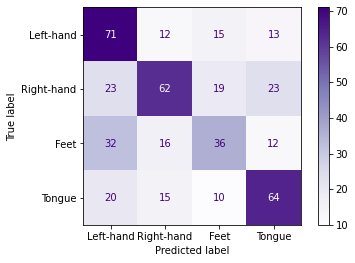

In [68]:
Y_pred = new_model.predict([x_test_np])
Y_pred = np.argmax(Y_pred, axis=1)
Y_test = np.argmax(y_test_np, axis=1)

labels = ["Left-hand", "Right-hand", "Feet", "Tongue"]
cm = confusion_matrix(Y_test, Y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Purples)
plt.show()